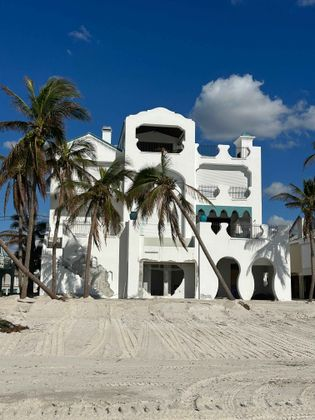

In [1]:
%load_ext autoreload
%autoreload 2

from plonk.pipe import PlonkPipeline
from PIL import Image
import torch
from IPython.display import display
device = torch.device("cuda") # GPU mostly necessary to get the likelihood map fast

image_path = "1.jpg"
example_image = Image.open(image_path)
display(example_image)

In [2]:
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

INSTALL = True
if INSTALL:
    !{sys.executable} -m pip install -U scikit-image scikit-learn ipywidgets



using dinov2_vitl14 model


Using cache found in /home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main
/home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:45: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:29: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home//t21bfade/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:35: UserWarning: xFormers is disabled (Block)
  warnings.w

patch size: 14


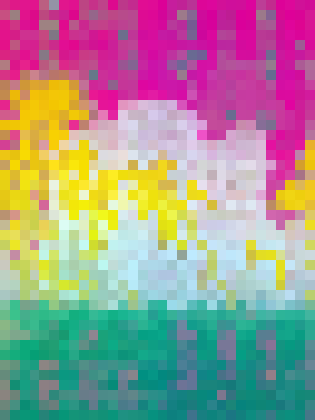

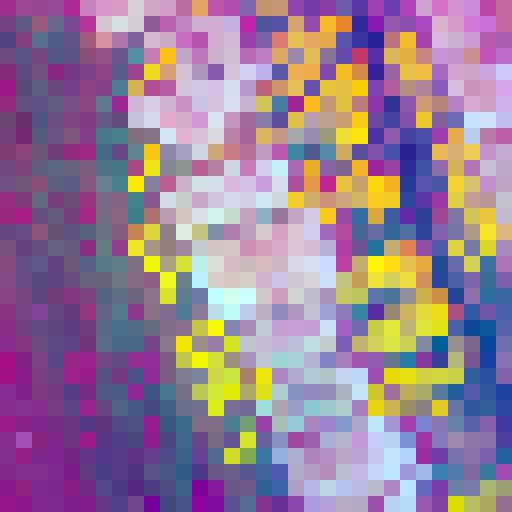

In [3]:
from typing import Tuple

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms


REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitl14"


DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False,
                    pca=None) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()
    if pca:
        pass
    else:
        pca = PCA(n_components=3)
        pca.fit(tokens)
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), 0), pca



print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
print(f"patch size: {model.patch_size}")

vgi_image, pca = render_patch_pca(image=example_image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

image_path_rsi = "1_rsi.jpg"
example_rsi = Image.open(image_path_rsi)
rsi_image, _ = render_patch_pca(image=example_rsi,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING,
                pca=pca)
display(vgi_image)
display(rsi_image)